In [151]:
#Importing pandas library 
import pandas as pd

import numpy as np

#Creating the subplots using matplotlib
import matplotlib.pyplot as plt

#Importing sklearn to train & test dataset
from sklearn.model_selection import train_test_split

#Importing linear model
from sklearn import linear_model

#Importing MSE, R2_score to get the models performance
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression as lm

#Importing pytorch library
import torch

#Importing 1D-Convolution
from torch.nn import Conv1d

from torch.nn import MaxPool1d

from torch.nn import Flatten

from torch.nn import Linear

#Importing activation function-ReLU
from torch.nn.functional import relu

from torch.utils.data import DataLoader, TensorDataset

from torch.optim import SGD,Adamax

from torch.nn import L1Loss

!pip install pytorch-ignite
from ignite.contrib.metrics.regression.r2_score import R2Score

In [152]:
#Reading the .csv file
house=pd.read_csv('/content/housing.csv')

#Dropping NA values.
house=house.dropna()

#Printing the first ten records of the dataset.
print('The first 10 records: ')
house.head(10)

The first 10 records: 


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f16f4d4e6d8>,
      dtype=object)

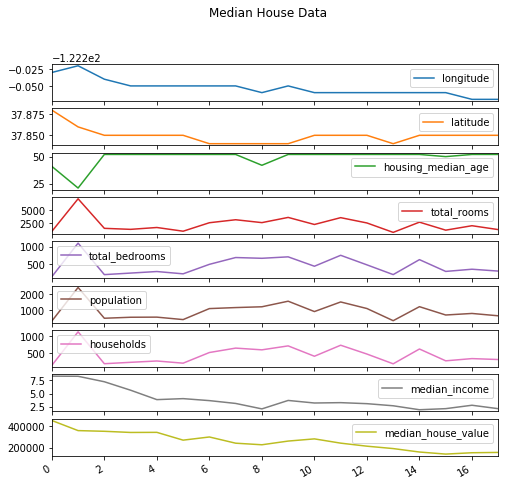

In [153]:
house.head(18).plot.line(subplots=True,figsize=(8, 8),title="Median House Data")

#axes = house.plot.line(subplots=True,figsize=(20, 10))
#plt.tight_layout()

In [154]:
#Implementing Conv1D to predict median house value
Y=house['median_house_value']
X=house.loc[:,'longitude':'median_income']

#Splitting dataset: 70% training & 30% testing
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.3, random_state=2003)

x_train_np=x_train.to_numpy()
y_train_np=y_train.to_numpy()

x_test_np=x_test.to_numpy()
y_test_np=y_test.to_numpy()

print(x_train.shape,x_test.shape,y_train.shape,y_test.shape )

(14303, 8) (6130, 8) (14303,) (6130,)


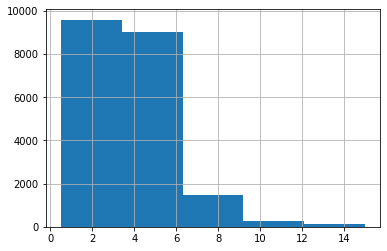

In [155]:
house['median_income'].hist(bins=5)
#Fitting a model
#lm = linear_model.LinearRegression()
#model = lm.fit(x_train, y_train)
#predictions = lm.predict(x_test)
#predictions

#lm = linear_model.LinearRegression()
#model=lm().fit(x_train,y_train)
#predictions=model.predict(x_test)

#plt.scatter(y_test,predictions)

In [0]:
class CnnRegressor(torch.nn.Module):
  def __init__(self,batch_size,inputs,outputs):
    super(CnnRegressor,self). __init__()
    self.batch_size=batch_size
    self.inputs=inputs
    self.outputs=outputs

    self.input_layer=Conv1d(inputs,batch_size,1)
    self.max_pooling_layer=MaxPool1d(1)
    self.conv_layer=Conv1d(batch_size,128,1)
    self.flatten_layer=Flatten()
    self.linear_layer=Linear(128,64)
    self.output_layer=Linear(64,outputs)

  def feed(self,input):
    input=input.reshape((self.batch_size,self.inputs,1))
    output=relu(self.input_layer(input))
    output=self.max_pooling_layer(output)
    output=relu(self.conv_layer(output))
    output=self.flatten_layer(output)
    output=self.linear_layer(output)
    output=self.output_layer(output)
    return output

In [157]:
batch_size=64
model=CnnRegressor(batch_size,X.shape[1],1)
model.cuda()
#model.summary()

CnnRegressor(
  (input_layer): Conv1d(8, 64, kernel_size=(1,), stride=(1,))
  (max_pooling_layer): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv_layer): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
  (flatten_layer): Flatten()
  (linear_layer): Linear(in_features=128, out_features=64, bias=True)
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [0]:
def model_loss(model,dataset,train=False,optimizer=None):
  performance=L1Loss()
  score_metric=R2Score()
  avg_loss=0
  avg_score=0
  count=0
  for input,output in iter(dataset):
    predictions=model.feed(input)
    loss=performance(predictions,output)
    score_metric.update([predictions,output])
    score=score_metric.compute()
    if(train):
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    avg_loss+=loss.item()
    avg_score+=score
    count+=1
  print(count) 
  return avg_loss/count,avg_score/count

In [159]:
epochs=1000
optimizer=SGD(model.parameters(),lr=1e-5)
optimizer=Adamax(model.parameters())
inputs=torch.from_numpy(x_train_np).cuda().float()
outputs=torch.from_numpy(y_train_np.reshape(y_train_np.shape[0],1)).cuda().float()
tensor=TensorDataset(inputs,outputs)
loader=DataLoader(tensor,batch_size,shuffle=True,drop_last=True)
for epoch in range(epochs):
  avg_loss,avg_r2_score=model_loss(model,loader,train=True,optimizer=optimizer)
  print("Epoch"+str(epoch+1)+":\n\tLoss="+str(avg_loss)+"\n\tR^2Score="+str(avg_r2_score))


223
Epoch1:
	Loss=134202.17727017938
	R^2Score=-2.1241972464858017
223
Epoch2:
	Loss=107135.61238789238
	R^2Score=-0.8836346876716827
223
Epoch3:
	Loss=88587.82991171525
	R^2Score=-0.29964300836315066
223
Epoch4:
	Loss=80452.26751681614
	R^2Score=0.11708425493163953
223
Epoch5:
	Loss=78862.57260720292
	R^2Score=0.17651249717663348
223
Epoch6:
	Loss=77857.90509389013
	R^2Score=0.23561438510600463
223
Epoch7:
	Loss=76650.93984725336
	R^2Score=0.2541838678562764
223
Epoch8:
	Loss=75759.72801639573
	R^2Score=0.26109261411265977
223
Epoch9:
	Loss=74376.42243553812
	R^2Score=0.2731935622623048
223
Epoch10:
	Loss=73050.86724005044
	R^2Score=0.3080063771032299
223
Epoch11:
	Loss=71538.31288536996
	R^2Score=0.3173928618995976
223
Epoch12:
	Loss=69893.99903657511
	R^2Score=0.3587649978989398
223
Epoch13:
	Loss=68664.86955227017
	R^2Score=0.3877721029753837
223
Epoch14:
	Loss=67586.27734375
	R^2Score=0.4056333078071772
223
Epoch15:
	Loss=66511.64122057175
	R^2Score=0.4168591440321449
223
Epoch16:

In [160]:
inputs=torch.from_numpy(x_test_np).cuda().float()
outputs=torch.from_numpy(y_test_np.reshape(y_test_np.shape[0],1)).cuda().float()
tensor=TensorDataset(inputs,outputs)
loader=DataLoader(tensor,batch_size,shuffle=True,drop_last=True)
avg_loss,avg_r2_score=model_loss(model,loader)
print("Themodel'sL1lossis:"+str(avg_loss))
print("Themodel'sR^2scoreis:"+str(avg_r2_score))

95
Themodel'sL1lossis:44087.50567434211
Themodel'sR^2scoreis:0.7101141943362222


In [161]:

torch.save(model,"1121153_1dconv_reg.pth")

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type CnnRegressor. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
